`Classify 5 types of flowers with convulutioanal networks`

## Load necessary Libraries and Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
import tensorflow.keras as keras

import warnings
warnings.filterwarnings('ignore')


SEED = 1234
np.random.seed(SEED)
# setting random seed for only tf
tf.random.set_seed(SEED)  # only for seeeding graphs??
# for all py, np, tf
# keras.utils.set_random_seed(SEED)

# def set_global_determinism(seed=SEED):
#     set_seeds(seed=seed)

#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
#     tf.config.threading.set_inter_op_parallelism_threads(1)
#     tf.config.threading.set_intra_op_parallelism_threads(1)

# # Call the above function with seed value
# set_global_determinism(seed=SEED)

### wandb stuff

In [2]:
%env "WANDB_NOTEBOOK_NAME" 'Flower_classification TF'
wandb.login()

env: "WANDB_NOTEBOOK_NAME"='Flower_classification TF'


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: k_loki. Use `wandb login --relogin` to force relogin


True

In [73]:
wandb.init(project='tf-flower-classification-2',)
wandb.config = {
    "BATCH_SIZE" : 32,
    "IMG_SIZE" : (128, 128),
    "EPOCHS" : 10,
    "Lerning_Rate": 0.001
}
wandb.run.name = 'still y model lags??'

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
EPOCHS = 10

In [8]:
data_path  = Path(r'D:\ML\cv\Flowers classification\data\flowers')

[path for path in data_path.iterdir()]

[WindowsPath('D:/ML/cv/Flowers classification/data/flowers/daisy'),
 WindowsPath('D:/ML/cv/Flowers classification/data/flowers/dandelion'),
 WindowsPath('D:/ML/cv/Flowers classification/data/flowers/rose'),
 WindowsPath('D:/ML/cv/Flowers classification/data/flowers/sunflower'),
 WindowsPath('D:/ML/cv/Flowers classification/data/flowers/tulip')]

In [9]:
daisy = data_path/'daisy'
dand = data_path/'dandelion'
sun  = data_path/'sunflower'
tulip = data_path/'tulip'
rose = data_path/'rose'

flowers = [daisy, dand, sun, rose, tulip]

In [10]:
# what is the apporx size of the img
for d in os.listdir(daisy):
    img = plt.imread(daisy/d)
    print(img.shape)
    break

(263, 320, 3)


In [11]:
# no. of imgs in each flower category
for flower in flowers:
    print(flower.stem, end=': ')
    print(len(os.listdir(flower)))

daisy: 769
dandelion: 1055
sunflower: 734
rose: 784
tulip: 984


### Plot random images to see what they look like

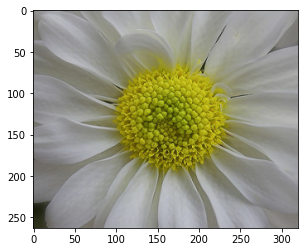

In [7]:
# random daisy image
img_path = os.listdir(daisy)[0]
img = plt.imread(daisy/img_path)
plt.imshow(img)

In [8]:
# load img with cv2
img = cv2.imread(str(daisy/img_path))
print(img.shape)
cv2.imshow('', img)
cv2.waitKey(0)

(263, 320, 3)


-1

In [9]:
def get_rand_imgs(f_path):
    n_imgs = (3, 3)
    fig, axis = plt.subplots(*n_imgs, figsize=(7,7))
    img_paths = [os.listdir(f_path)[x] for x in np.random.randint(0, 700, size=3*3)]
    # plot imgs
    axis = axis.ravel()
    for i in range(9):
        img = plt.imread(f_path/img_paths[i])
        axis[i].imshow(img)
        axis[i].set_axis_off()
    fig.suptitle(f_path.stem)
    fig.tight_layout()

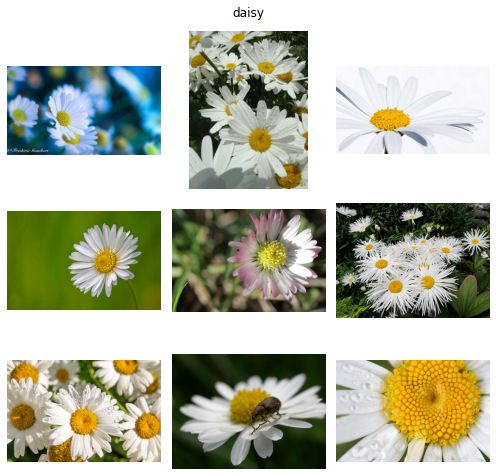

In [10]:
get_rand_imgs(daisy)

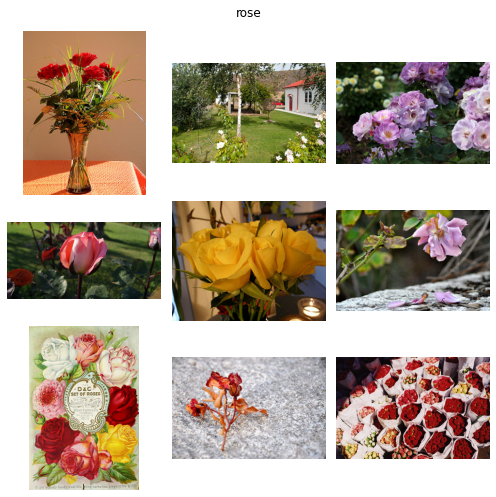

In [11]:
get_rand_imgs(rose)

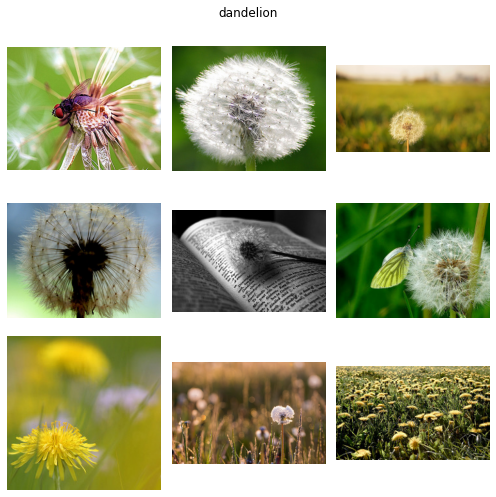

In [12]:
get_rand_imgs(dand)

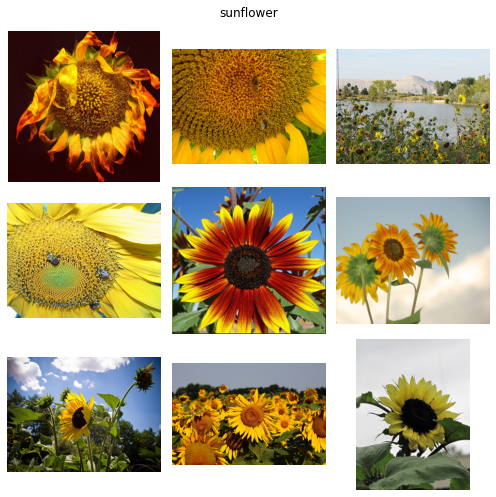

In [13]:
get_rand_imgs(sun)

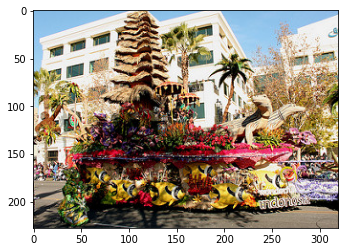

In [14]:
img_path = os.listdir(rose)[7]
img = plt.imread(rose/img_path)
plt.imshow(img)
# Lol.. is this a rose.??

## Data Preparation

In [12]:
flower_labels = os.listdir(data_path)
flower_labels

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [13]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_path, 
    image_size=IMG_SIZE, 
    seed=SEED,
    validation_split=0.2, 
    subset='training',
    # color_mode='grayscale',
    batch_size=BATCH_SIZE,
    shuffle=True
    )

val_ds  = keras.preprocessing.image_dataset_from_directory(
    data_path, 
    image_size=IMG_SIZE, 
    seed=SEED,
    validation_split=0.2, 
    subset='validation',
    # color_mode='grayscale',
    batch_size=BATCH_SIZE,
    shuffle=True
    )

Found 4323 files belonging to 5 classes.
Using 3459 files for training.
Found 4323 files belonging to 5 classes.
Using 864 files for validation.


In [14]:
for something in train_ds.take(1):
    print(something[1])

tf.Tensor([1 4 2 4 4 3 2 4 1 0 4 4 4 1 1 0 4 2 0 4 3 0 4 2 1 4 3 1 0 2 1 4], shape=(32,), dtype=int32)


In [15]:
#  Normalize pixel values
# cause the dataset returns pixel values and img labels remember??
# def normalize(x,y):
#     return x/255.0, y

train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds = val_ds.map(lambda x, y: (x/255.0, y))

(128, 128, 3)


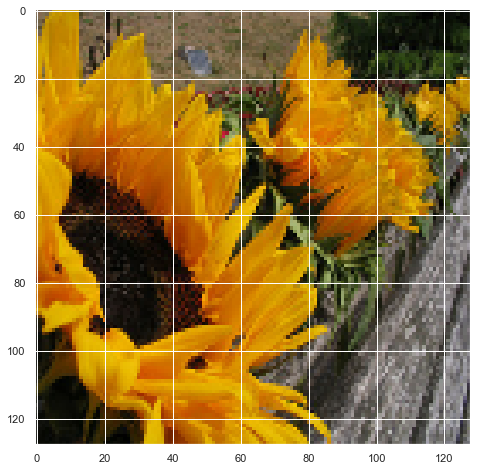

In [64]:
for img in train_ds.take(1):
    print(img[0][0].shape)
    plt.imshow(img[0][31])

## Build a classifier Model

In [57]:
def get_conv_model():
    #  a simple conv model using keras functional api
    inputs = keras.layers.Input(shape=(128, 128, 3))
    x = keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inputs)  # conv2d is from keras api2.0 others are being deprcated and both conv2d and convolution2d mean the same.
    x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.MaxPool2D()(x)
    # flatten the conv features 
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(5, activation='softmax')(x) # if no softmax outputs will be logits, not probs....

    conv_model = keras.models.Model(inputs, outputs, name='f_clf')

    # compile
    conv_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return conv_model

In [58]:
conv_model = get_conv_model()
conv_model.summary()

Model: "f_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        18496 

In [21]:
# hist = conv_model.fit(train_ds, validation_data=val_ds, epochs=10)  

In [22]:
# epochs = hist.epoch
# val_acc = hist.history.get('val_accuracy')
# train_acc = hist.history.get('accuracy')

In [23]:
# plt.plot(epochs, train_acc, label='Training acc', c='g')
# plt.plot(epochs, val_acc, label='Validation acc', c='r')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.tight_layout()
# # this is exactly overfitting...
# # the model seems to be so large that it remembers the traing set --> classical example for overfitting

In [24]:
# conv_model.evaluate(val_ds)

## Fight overfitting

In [59]:
inp = keras.layers.Input(shape=(128, 128, 3))
x = keras.layers.RandomFlip('horizontal')(inp)
x  = keras.layers.RandomRotation(0.1)(x)
out = keras.layers.RandomZoom(0.1)(x)

data_aug = keras.models.Model(inp, out)
data_aug.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


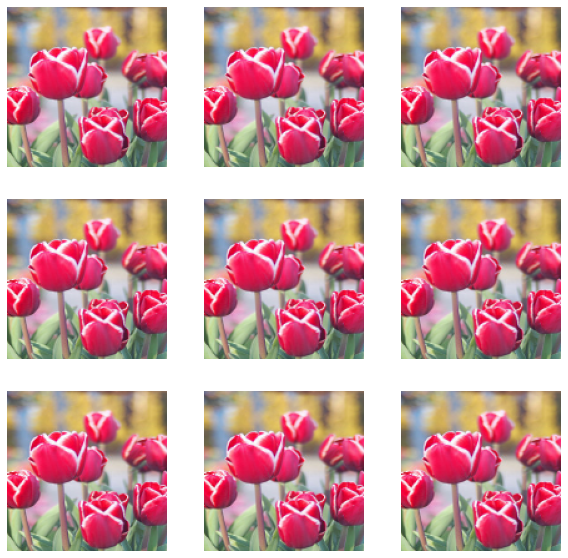

In [72]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_aug(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy())
    plt.axis("off")

In [60]:
dont_overfit = keras.models.Model(data_aug.input, conv_model(data_aug.output))
dont_overfit.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dont_overfit.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
 f_clf (Functional)          (None, 5)                 4219429   
                                                                 
Total params: 4,219,429
Trainable params: 4,219,429
Non-trainable params: 0
_________________________________________________

In [65]:
wandb.config.update({"IMG_SIZE":(128, 128, 3)})
# wandb_callback = WandbCallback(log_weights=True, log_gradients=True, save_model=False, training_data=train_ds)
wandb_callback =  WandbCallback(save_model=False)

In [66]:
do_hist = dont_overfit.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[wandb_callback])

Epoch 1/10
109/109 [==============================] - 13s 94ms/step - loss: 1.4630 - accuracy: 0.3660 - val_loss: 1.2254 - val_accuracy: 0.4907 - _timestamp: 1656241489.0000 - _runtime: 43.0000
Epoch 2/10
109/109 [==============================] - 8s 70ms/step - loss: 1.1204 - accuracy: 0.5392 - val_loss: 1.0821 - val_accuracy: 0.5787 - _timestamp: 1656241497.0000 - _runtime: 51.0000
Epoch 3/10
109/109 [==============================] - 7s 66ms/step - loss: 1.0054 - accuracy: 0.6062 - val_loss: 1.0204 - val_accuracy: 0.5995 - _timestamp: 1656241504.0000 - _runtime: 58.0000
Epoch 4/10
109/109 [==============================] - 8s 69ms/step - loss: 0.9427 - accuracy: 0.6366 - val_loss: 1.0406 - val_accuracy: 0.5845 - _timestamp: 1656241512.0000 - _runtime: 66.0000
Epoch 5/10
109/109 [==============================] - 9s 76ms/step - loss: 0.8814 - accuracy: 0.6513 - val_loss: 0.9518 - val_accuracy: 0.6308 - _timestamp: 1656241521.0000 - _runtime: 75.0000
Epoch 6/10
109/109 [==============

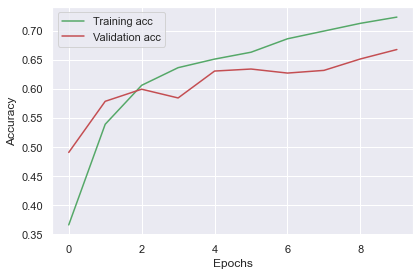

In [70]:
epochs = do_hist.epoch
val_acc = do_hist.history.get('val_accuracy')
train_acc = do_hist.history.get('accuracy')

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, label='Training acc', c='g')
plt.plot(epochs, val_acc, label='Validation acc', c='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
# better than earlier....

In [68]:
dont_overfit.evaluate(val_ds)

27/27 [==============================] - 1s 33ms/step - loss: 0.8427 - accuracy: 0.6678


[0.8427428007125854, 0.6678240895271301]

1/1 [==============================] - 0s 149ms/step


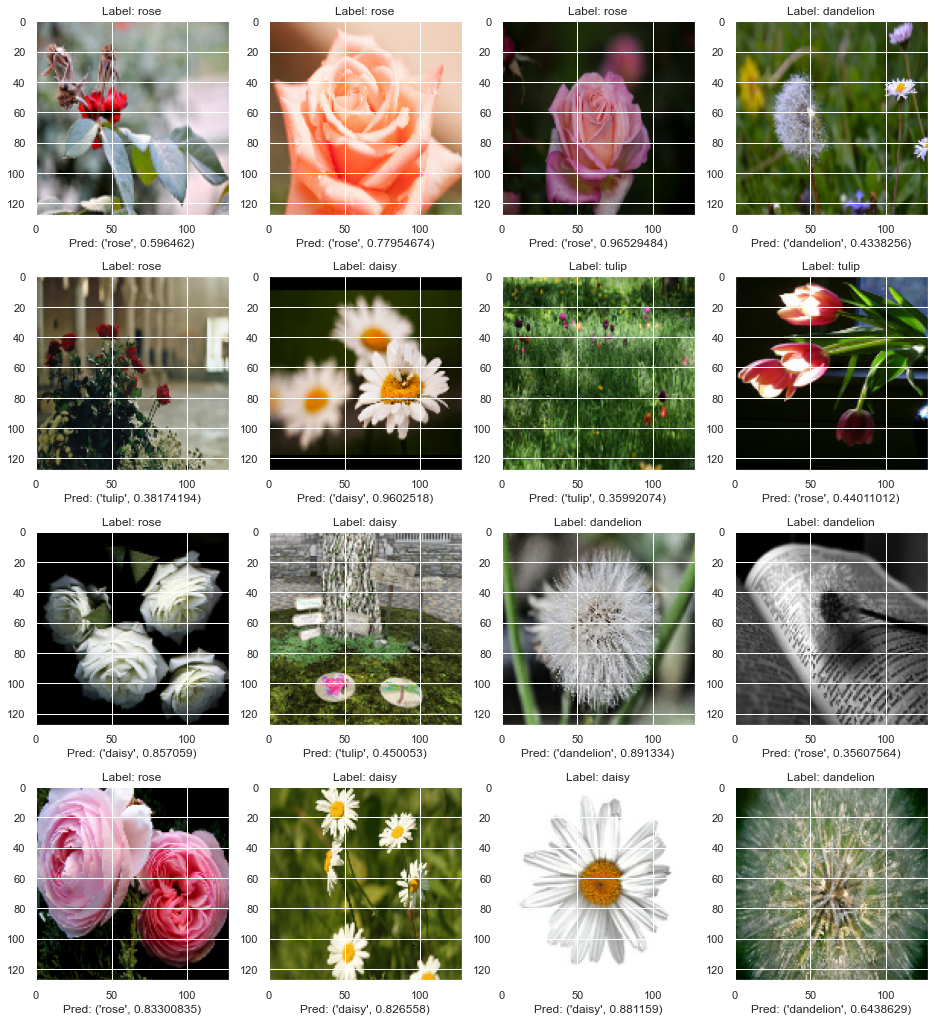

In [69]:
#  see a few results of model performance
for ft, label in val_ds.take(1).as_numpy_iterator():
    preds = dont_overfit.predict(ft)
    pred_label = np.argmax(preds, axis=1)
    pred_prob = np.max(preds, axis=1)
    predictions = [(flower_labels[x], pred_prob[i]) for i, x in enumerate(pred_label)]
    labels = [flower_labels[x] for x in label]
    fig, ax = plt.subplots(4,4, figsize=(16,18))
    for idx,ax in enumerate(ax.reshape(-1)):
        ax.imshow(ft[idx])
        ax.set_title(f"Label: {labels[idx]}")
        ax.set_xlabel(f'Pred: {predictions[idx]}')
        # ax.axis('off')
    break

<AxesSubplot:>

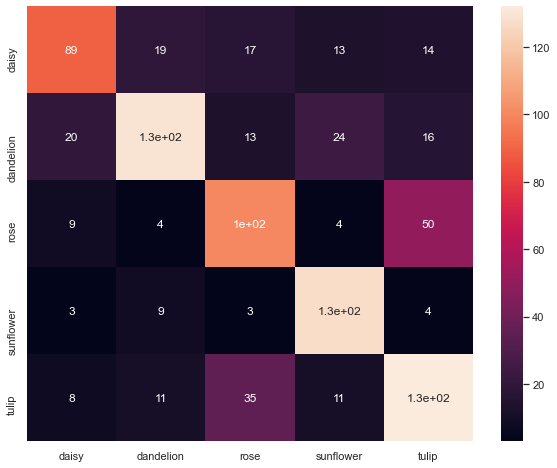

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = []
labels = []
for ft, label in val_ds.as_numpy_iterator():
    preds = dont_overfit.predict(ft, verbose=False)
    preds = np.argmax(preds, axis=1)
    predictions.extend(preds)
    labels.extend(label)

sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(confusion_matrix(labels, predictions), yticklabels=flower_labels, xticklabels=flower_labels, annot=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)       

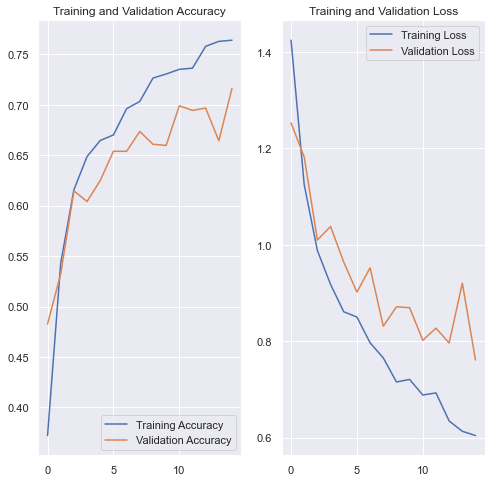

In [76]:
# why doc model is performing better...???

data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal",
                      input_shape=(128,
                                  128,
                                  3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ]
)


model = keras.models.Sequential([
  data_augmentation,
  # keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())
# Loll.. they are run for 15 epochs
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[wandb_callback]
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
wandb.finish()

accuracy,▁▁▁▁▃▅▆▆▇▇▇▇▇██████
epoch,▁▁▂▃▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,████▇▅▄▃▃▃▂▂▂▂▂▂▁▁▁
val_accuracy,▁▁▁▁▅▅▇▆▇▇▇▇▇▇███▇█
val_loss,████▅▄▃▃▃▂▃▂▂▂▁▂▁▂▁
accuracy,0.76409
best_epoch,14
best_val_loss,0.76073
epoch,14
loss,0.60423
val_accuracy,0.71644
